# Boltzmann Wealth Model

# Basic Overview

The agent based model comes with 2 parts.  The model itself and the individual agents within the model.
First, we impor the relevant classes from the Mesa module and create an Agent and Model.

In [1]:
from mesa import Model, Agent

In [2]:
class MoneyAgent(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id):
        # Each agent should have a unique identifier, stored in the unique_id field.
        self.unique_id = unique_id
        self.wealth = 1

In [3]:
class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N):
        self.num_agents = N
        # The scheduler will be added here
        self.create_agents()
        
    def create_agents(self):
        """Method to create all the agents."""
        for i in range(self.num_agents):
            a = MoneyAgent(i)
            # Now what? See below.

With the classes defined, we can now initialize and create the model and populate it with agents.

In [4]:
money_model = MoneyModel(10)
money_model.create_agents()

# Scheduler

A Schedule defines what each agent will do during each time tick of the simulation.
In this example we are using the `RandomActivation` schedule from `mesa.time`.

In the `MoneyModel` we need to

1.  Create the schedule we would like each agent to use.
2.  Add agents to the schedule when they are created
3.  Define a model step function that determines what the model will do at each step

In the `MoneyAgent` we need to

1.  Define a Step function that determines what each agent that is selected during a model step will do.

In [5]:
import random

from mesa import Model, Agent
from mesa.time import RandomActivation


class MoneyAgent(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id):
        self.unique_id = unique_id
        self.wealth = 1

    def step(self, model):
        """Give money to another agent."""
        if self.wealth > 0:
            # Pick a random agent
            other = random.choice(model.schedule.agents)
            # Give them 1 unit money
            other.wealth += 1
            self.wealth -= 1


class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N):
        self.num_agents = N
        # Adding the scheduler:
        # Scheduler needs to be created before agents do
        # Scheduler objects are instantiated with their model object,
        # which they then pass to the agents at each step.
        self.schedule = RandomActivation(self)
        self.create_agents()

    def create_agents(self):
        """Method to create all the agents."""
        for i in range(self.num_agents):
            a = MoneyAgent(i)
            self.schedule.add(a)

    def step(self):
        # The scheduler's step method activates the step methods of all the
        # agents that have been added to it, in this case in random order.
        self.schedule.step()

    def run_model(self, steps):
        # Because the model has no inherent end conditions,
        # the user must specify how many steps to run it for.
        for i in range(steps):
            self.step()


With the newly updated code, we can create the model and agents (just like above).
Since we defined a schedule, we can now tell the model to run for `n` number of steps, in this example, we picked `5`.

In [6]:
money_model = MoneyModel(10)
money_model.create_agents()
money_model.run_model(5)

# Space

In order to assign a location to an agent we need to provide a grid or space to assign coordinates to the agents.
We get this from the `mesa.space` module.

Since agents have a coordinate, we can also define a `move` method.

In [7]:
import random

from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import MultiGrid


class MoneyAgent(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id):
        self.unique_id = unique_id
        self.wealth = 1

    def step(self, model):
        """Give money to another agent."""
        if self.wealth > 0:
            # Pick a random agent
            other = random.choice(model.schedule.agents)
            # Give them 1 unit money
            other.wealth += 1
            self.wealth -= 1

    def move(self, model):
        """Take a random step."""
        grid = model.grid
        # The get_neighborhood method returns a list of coordinate tuples for
        # the appropriate neighbors of the given coordinates. In this case,
        # it's getting the Moore neighborhood (including diagonals) and
        # includes the center cell. The agent decides where to move by choosing
        # one of those tuples at random. This is a good way of handling random
        # moves, since it still works for agents on an edge of a non-toroidal
        # grid, or if the grid itself is hexagonal.
        possible_steps = grid.get_neighborhood(
            self.pos, moore=True, include_center=True)
        choice = random.choice(possible_steps)
        # the move_agent method works like place_agent, but removes the agent
        # from its current location before placing it in its new one.
        grid.move_agent(self, choice)

    def give_money(self, model):
        grid = model.grid
        pos = [self.pos]
        # This is a helper method which returns the contents of the entire list
        # of cell tuples provided. It's not strictly necessary here; the
        # alternative would be: x, y = self.pos; others = grid[y][x]
        # (note that grids are indexed y-first).
        others = grid.get_cell_list_contents(pos)
        if len(others) > 1:
            other = random.choice(others)
            other.wealth += 1
            self.wealth -= 1


class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N, width, height, torus):
        # The arguments needed to create a new grid are its
        # width, height, and a boolean for whether it is a torus or not.
        self.grid = MultiGrid(height, width, torus)
        self.num_agents = N
        self.schedule = RandomActivation(self)
        self.create_agents()

    def create_agents(self):
        """Method to create all the agents."""
        for i in range(self.num_agents):
            a = MoneyAgent(i)
            self.schedule.add(a)
            x = random.randrange(self.grid.width)
            y = random.randrange(self.grid.width)
            # The place_agent method places the given object in the grid cell
            # specified by the (x, y) tuple, and assigns that tuple to the
            # agent's pos property.
            self.grid.place_agent(a, (x, y))

    def step(self):
        # The scheduler's step method activates the step methods of all the
        # agents that have been added to it, in this case in random order.
        self.schedule.step()

    def run_model(self, steps):
        # Because the model has no inherent end conditions,
        # the user must specify how many steps to run it for.
        for i in range(steps):
            self.step()


Here, we create a model with `N` agents, with `with` and `height` of 50.

In [8]:
money_model = MoneyModel(N=100, width=50, height=50, torus=True)
money_model.create_agents()
money_model.run_model(50)

Since our agents are on a coordinate plane, and each agent has a wealth value, we can plot our data!

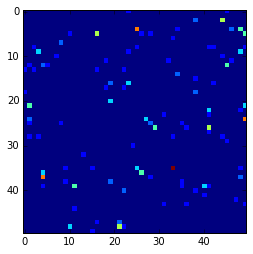

In [9]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

wealth_grid = np.zeros((money_model.grid.width, money_model.grid.height))

for cell in money_model.grid.coord_iter():
    cell_content, x, y = cell
    cell_wealth = sum(a.wealth for a in cell_content)
    wealth_grid[y][x] = cell_wealth
    
plt.imshow(wealth_grid, interpolation='nearest')
plt.show()

# Data Collection

Generic DataCollector class, which can store and export data from most models without needing to be subclassed.

The data collector stores three categories of data: model-level variables, agent-level variables, and tables which are a catch-all for everything else.

Internally, the data collector stores all variables and tables in Python's standard dictionaries and lists. This reduces the need for external dependencies, and allows the data to be easily exported to JSON or CSV. However, one of the goals of Mesa is facilitating integration with Python's larger scientific and data-analysis ecosystems, and thus the data collector also includes methods for exporting the collected data to pandas data frames. This allows rapid, interactive processing of the data, easy charting, and access to the full range of statistical and machine-learning tools that are compatible with pandas.

**Since data is not written out to a file, large simulations cannot be run yet.  A way to append values to a external CSV is being developed so data does not need to be persisted in memory**

```python

from mesa.datacollector import DataCollector

class MoneyModel(Model):

  def __init__(self, N):
    # ... everything above
    ar = {"Wealth": lambda a: a.wealth}
    self.dc = DataCollector(agent_reporters=ar)

  def step(self):
    self.dc.collect(self)
    self.schedule.step()
```

In [10]:
import random

from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector


class MoneyAgent(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id):
        self.unique_id = unique_id
        self.wealth = 1

    def step(self, model):
        """Give money to another agent."""
        if self.wealth > 0:
            # Pick a random agent
            other = random.choice(model.schedule.agents)
            # Give them 1 unit money
            other.wealth += 1
            self.wealth -= 1

    def move(self, model):
        """Take a random step."""
        grid = model.grid
        # The get_neighborhood method returns a list of coordinate tuples for
        # the appropriate neighbors of the given coordinates. In this case,
        # it's getting the Moore neighborhood (including diagonals) and
        # includes the center cell. The agent decides where to move by choosing
        # one of those tuples at random. This is a good way of handling random
        # moves, since it still works for agents on an edge of a non-toroidal
        # grid, or if the grid itself is hexagonal.
        possible_steps = grid.get_neighborhood(
            self.pos, moore=True, include_center=True)
        choice = random.choice(possible_steps)
        # the move_agent method works like place_agent, but removes the agent
        # from its current location before placing it in its new one.
        grid.move_agent(self, choice)

    def give_money(self, model):
        grid = model.grid
        pos = [self.pos]
        # This is a helper method which returns the contents of the entire list
        # of cell tuples provided. It's not strictly necessary here; the
        # alternative would be: x, y = self.pos; others = grid[y][x]
        # (note that grids are indexed y-first).
        others = grid.get_cell_list_contents(pos)
        if len(others) > 1:
            other = random.choice(others)
            other.wealth += 1
            self.wealth -= 1


class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N, width, height, torus):
        # The arguments needed to create a new grid are its
        # width, height, and a boolean for whether it is a torus or not.
        self.grid = MultiGrid(height, width, torus)
        self.num_agents = N
        self.schedule = RandomActivation(self)
        self.create_agents()
        ar = {"Wealth": lambda a: a.wealth}
        self.dc = DataCollector(agent_reporters=ar)

    def create_agents(self):
        """Method to create all the agents."""
        for i in range(self.num_agents):
            a = MoneyAgent(i)
            self.schedule.add(a)
            x = random.randrange(self.grid.width)
            y = random.randrange(self.grid.width)
            # The place_agent method places the given object in the grid cell
            # specified by the (x, y) tuple, and assigns that tuple to the
            # agent's pos property.
            self.grid.place_agent(a, (x, y))

    def step(self):
        # The scheduler's step method activates the step methods of all the
        # agents that have been added to it, in this case in random order.
        self.schedule.step()
        self.dc.collect(self)

    def run_model(self, steps):
        # Because the model has no inherent end conditions,
        # the user must specify how many steps to run it for.
        for i in range(steps):
            self.step()


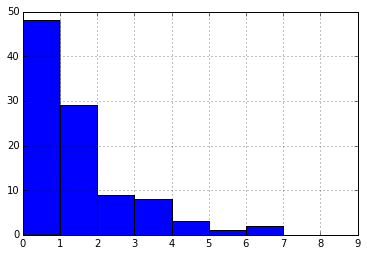

In [11]:
# Create a model with 100 agents
model = MoneyModel(100, 10, 10, True)
# Run it for 1,000 steps:
model.run_model(1000)
# Get the data as a DataFrame
wealth_history = model.dc.get_agent_vars_dataframe()
# wealth_history indexed on Step and AgentID, and...
# ...has Wealth as one data column
wealth_history.reset_index(inplace=True)
# Plot a histogram of final wealth
wealth_history[wealth_history.Step==999].\
  Wealth.hist(bins=range(10))

# Batch Runner

Since most ABMs are stochastic, a single model run gives us only one particular realization of the process the model describes. Furthermore, the questions we want to use ABMs to answer are often about how a particular parameter drives the behavior of the entire system -- requiring multiple model runs with different parameter values. In order to facilitate this, Mesa provides the BatchRunner class. Like the DataCollector, it does not need to be subclassed in order to conduct parameter sweeps on most models.

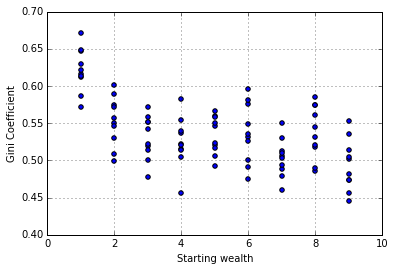

In [12]:
from mesa.batchrunner import BatchRunner

class MoneyAgent(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id, starting_wealth):
        # Each agent should have a unique_id
        self.unique_id = unique_id
        self.wealth = starting_wealth
    
    def step(self, model):
        """Give money to another agent."""
        if self.wealth > 0:
            # Pick a random agent
            other = random.choice(model.schedule.agents)
            # Give them 1 unit money
            other.wealth += 1
            self.wealth -= 1

class MoneyModel(Model):
    """A model with some number of agents."""
    
    def __init__(self, N, starting_wealth):
        self.running = True
        self.num_agents = N
        self.starting_wealth = starting_wealth
        self.schedule = RandomActivation(self)
        self.create_agents()
        ar = {"Wealth": lambda a: a.wealth}
        self.dc = DataCollector(agent_reporters=ar)

    def create_agents(self):
        """Method to create all the agents."""
        for i in range(self.num_agents):
            a = MoneyAgent(i, self.starting_wealth)
            self.schedule.add(a)
            
    def step(self):
        self.dc.collect(self)
        self.schedule.step()

    def run_model(self, steps):
        """The model has no end condition
        so the user needs to specify how long to run"""
        for _ in range(steps):
            self.step()

def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum( xi * (N-i) for i,xi in enumerate(x) ) / (N*sum(x))
    return (1 + (1/N) - 2*B)

param_values = {"N": 100, "starting_wealth": range(1,10)}
model_reporter={"Gini": compute_gini}
batch = BatchRunner(MoneyModel, param_values,
                  10, 1000, model_reporter)
batch.run_all()
out = batch.get_model_vars_dataframe()
plt.scatter(out.starting_wealth, out.Gini)

plt.grid(True)
plt.xlabel("Starting wealth")
plt.ylabel("Gini Coefficient")